In [1]:
import sys
sys.path.insert(0,'C:/Users/owner/Documents/Github/gym-warehouse')

import gym
import gym_warehouse
import numpy as np
import copy

env = gym.make('warehouse-v0')
env.reset()
# env.render()

pygame 1.9.5
Hello from the pygame community. https://www.pygame.org/contribute.html
SHAPE OF CLASS MAP:  (5, 10)


array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [2]:
# CNNDQN
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import math, random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# torch.manual_seed(1356)

# Device configuration
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# torch.cuda.manual_seed(1356)
# torch.backends.cudnn.deterministic = True

# out_dir = '/u/training/tra442/scratch/'
out_dir = 'outdir/'

# from wrappers import make_atari, wrap_deepmind, wrap_pytorch
# env    = make_atari(env_id)
# env    = wrap_deepmind(env)
# env    = wrap_pytorch(env)


import math, random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import matplotlib.pyplot as plt

USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

from collections import deque

gamma      = 0.99

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)

        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
#         print("STATE: ",state)
        return np.concatenate(state), action, reward, np.concatenate(next_state), done

    def __len__(self):
        return len(self.buffer)


def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())

# estimated_next_q_state_values=[]
# estimated_next_q_value=[]


class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CnnDQN, self).__init__()

        self.input_shape = input_shape
        self.num_actions = num_actions

        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)

    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0), volatile=True)
            q_value = self.forward(state)
#             print(q_value)
            action  = q_value.max(1)[1].data[0]
        else:
            action1 = random.randrange(5)
#             action2 = 5+random.randrange(5)
        return action1
    
    
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(num_inputs, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_actions)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True)
            q_value = self.forward(state)
#             print(q_value)
            q_1 = q_value[0][:-5]
            q_2 = q_value[0][5:]
#             print("WHEN IN DOUBT: ",q_1)
#             b[0][:-5].max(0)[0].item()
            action_1  = q_1.max(0)[1].data.item()
            action_2  = q_2.max(0)[1].data.item()
        else:
            action_1 = random.randrange(5)
            action_2 = random.randrange(5)
        return action_1,action_2

def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.savefig(out_dir + 'rewards.png')

    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.savefig(out_dir + 'losses.png')
    plt.show()
    
    

def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)))
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))

    q_values      = current_model(state)
#     q_values: batch_size x 10 possible actions
#     print("Q_VALUES: ",q_values)
    
    next_q_cur_values = current_model(next_state) #next_q_values
    next_q_tar_values = target_model(next_state) #next_q_state_values
    

#     estimated_next_q_state_values.append(next_q_tar_values)

#     print("Next_q_cur_values: ", next_q_cur_values)
#     print("Next_q_tar_values: ", next_q_tar_values)

    q_value       = q_values.gather(1, action)
#     32x2 (one for each action)

    temp1 = next_q_cur_values[:,:5] 
    temp2 = next_q_cur_values[:,5:]
    torch.max(temp2, 1)[1].unsqueeze(1)
    
    next_q_value_1 = next_q_tar_values.gather(1, torch.max(temp1, 1)[1].unsqueeze(1)).squeeze(1)
    next_q_value_2 = next_q_tar_values.gather(1, torch.max(temp2, 1)[1].unsqueeze(1)).squeeze(1)

#     estimated_next_q_value.append(next_q_value)
    
    reward_1 = reward[:,[0]].squeeze(1)
    reward_2 = reward[:,[1]].squeeze(1)
    
    expected_q_value_1 = reward_1 + gamma * next_q_value_1 * (1 - done)
    expected_q_value_2 = reward_2 + gamma * next_q_value_2 * (1 - done)
    
    
    expected_q_value_1 = expected_q_value_1.unsqueeze(1)
    expected_q_value_2 = expected_q_value_2.unsqueeze(1)

    expected_q_value = torch.cat((expected_q_value_1,expected_q_value_2),1)
    
    loss = (q_value - Variable(expected_q_value.data)).pow(2).mean() 
#     + (q_value - Variable(expected_q_value_2.data)).pow(2).mean()
#     print("LOSS: ",loss)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

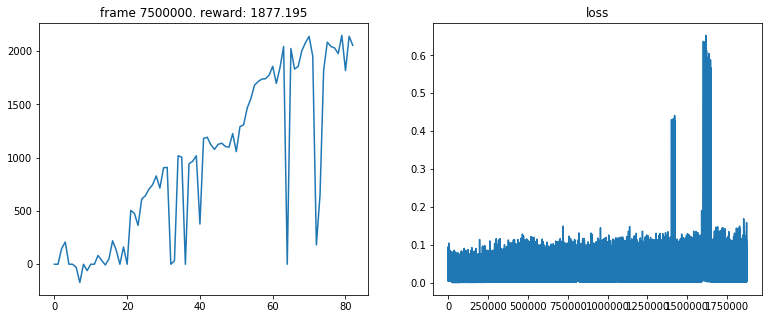

Frame:  7510000
Episode Reward: 1671.0700000012241
ALL REWARDS: [-6.090079135434578e-11, -0.01999999999267048, 148.31999999998288, 208.20999999967327, -0.009999999995265966, -0.010000000023495801, -29.93000000000831, -171.00000000001077, -0.0099999999969464, -59.940000000000026, -0.009999999990533751, -0.019999999994628027, 82.43000000000893, 35.5999999998576, -7.189999999996984, 50.5299999999006, 220.3799999996957, 132.25999999991708, -0.01999999993278594, 161.96000000022207, -1.3081819655313964e-10, 504.6500000006181, 477.1100000004466, 364.40000000058285, 612.0000000008529, 643.1200000007648, 705.2500000009308, 746.600000000885, 829.1900000009853, 714.6000000009658, 905.4100000011437, 909.8500000010607, -0.019999999507369793, 32.330000000903624, 1018.2200000011686, 1004.7600000011851, -0.010000000068309731, 943.2300000010093, 966.2000000012794, 1018.4000000010973, 377.2900000012627, 1181.0600000012414, 1192.2700000012396, 1122.6300000012948, 1078.1600000012922, 1125.5000000011005, 1

Frame:  7560000
Episode Reward: 998.2400000005279
ALL REWARDS: [-6.090079135434578e-11, -0.01999999999267048, 148.31999999998288, 208.20999999967327, -0.009999999995265966, -0.010000000023495801, -29.93000000000831, -171.00000000001077, -0.0099999999969464, -59.940000000000026, -0.009999999990533751, -0.019999999994628027, 82.43000000000893, 35.5999999998576, -7.189999999996984, 50.5299999999006, 220.3799999996957, 132.25999999991708, -0.01999999993278594, 161.96000000022207, -1.3081819655313964e-10, 504.6500000006181, 477.1100000004466, 364.40000000058285, 612.0000000008529, 643.1200000007648, 705.2500000009308, 746.600000000885, 829.1900000009853, 714.6000000009658, 905.4100000011437, 909.8500000010607, -0.019999999507369793, 32.330000000903624, 1018.2200000011686, 1004.7600000011851, -0.010000000068309731, 943.2300000010093, 966.2000000012794, 1018.4000000010973, 377.2900000012627, 1181.0600000012414, 1192.2700000012396, 1122.6300000012948, 1078.1600000012922, 1125.5000000011005, 11

In [ ]:
# current_model = CnnDQN(env.observation_space.shape, env.action_space.n)
# target_model  = CnnDQN(env.observation_space.shape, env.action_space.n)

current_model = DQN(env.observation_space.shape[0]*env.observation_space.shape[1], 10)
target_model  = DQN(env.observation_space.shape[0]*env.observation_space.shape[1], 10)


if USE_CUDA:
    current_model = current_model.cuda()
    target_model  = target_model.cuda()

optimizer = optim.Adam(current_model.parameters(), lr=0.00001)

replay_initial = 10000
replay_buffer = ReplayBuffer(100000)

update_target(current_model, target_model)

epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 10000000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

num_frames = 10000000
batch_size = 32


losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
state = state.flatten()
# env.render()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action_1,action_2 = current_model.act(state, epsilon)

    next_state, reward, done, _ = env.step([action_1,action_2])
    next_state=next_state.flatten()
    
#     print(state)
    if len(state)==2:
        raise RuntimeError("Length of observation is {} at frame {}".format(len(state),frame_idx))
    replay_buffer.push(state, [action_1,action_2], reward, next_state, done)
#     env.render()

    state = next_state
    episode_reward += reward[0]+reward[1]


    if (frame_idx%100000==0):
#         print("EPISODE REWARD: ", episode_reward)
        # SAVING LOSS AND REWARD
        np.save(out_dir + 'losses.npy',np.array(losses))
        np.save(out_dir + 'rewards.npy',np.array(all_rewards))

#         SAVING CHECKPOINTS
        torch.save(current_model.state_dict(),out_dir + 'current.ckpt'.format(frame_idx))
        torch.save(target_model.state_dict(),out_dir + 'target.ckpt'.format(frame_idx))

#         SAVING MODELS
        torch.save(current_model,out_dir + 'current.model')
        torch.save(target_model,out_dir + 'target.model')


    if done:
        state = env.reset()
        state = state.flatten()
        all_rewards.append(episode_reward)
        print("Episode Reward When Done: {}".format(episode_reward))
        episode_reward = 0


    if frame_idx % 10000==0:
        print('Frame: ',frame_idx)
        print("Episode Reward: {}".format(episode_reward))
        print("ALL REWARDS: {}".format(sum(all_rewards)))

    if (len(replay_buffer) > replay_initial) and (frame_idx%4==0):
        loss = compute_td_loss(batch_size)
        losses.append(loss.item())

    if frame_idx % 100000 == 0:
        plot(frame_idx, all_rewards, losses)

    if frame_idx % 100000 == 0:
        update_target(current_model, target_model)

In [ ]:
env.action_space

In [ ]:
b=torch.tensor([[-0.0814,  0.0060, -0.0667,  0.0217,  0.0114, -0.1569, -0.0728,  0.1463,
          0.0184, -0.1267]])

In [ ]:
len(next_state)

In [ ]:
b[0][:-5].max(0)[0].item()

In [ ]:
b = torch.tensor([[ 4.6634e-02, -8.4423e-02, -2.3318e-02,  1.6858e-02, -3.6122e-02,
          1.8666e-02, -1.1300e-01,  5.1002e-02,  1.7393e-02,  3.7890e-03],
        [ 1.8485e-02, -1.0614e-01, -5.6345e-02,  8.1009e-02, -2.0334e-02,
         -2.3780e-02, -1.0791e-02,  6.3356e-02, -1.7999e-02, -1.1104e-01]])
action = torch.tensor([[0, 4],
        [4, 4]])

In [ ]:
b.gather(1, action.unsqueeze(1)).squeeze(1)

In [ ]:
action.unsqueeze(1)

In [ ]:
b.gather(1,action)

In [ ]:
t = torch.tensor([[2,4],[3,4]])

In [ ]:
torch.gather(t,1,torch.tensor([[0,0],[1,1]]))

In [ ]:
next_q_cur_values = torch.tensor([[ 4.6634e-02, -8.4423e-02, -2.3318e-02,  1.6858e-02, -3.6122e-02,
          1.8666e-02, -1.1300e-01,  5.1002e-02,  1.7393e-02,  3.7890e-03],
        [ 1.8485e-02, -1.0614e-01, -5.6345e-02,  8.1009e-02, -2.0334e-02,
         -2.3780e-02, -1.0791e-02,  6.3356e-02, -1.7999e-02, -1.1104e-01]])

In [ ]:
temp1 = next_q_cur_values[:,:5] 
print(temp1)

In [ ]:
torch.max(temp1, 1)[1].unsqueeze(1)

In [ ]:
temp2 = next_q_cur_values[:,5:]
print(temp2)

In [ ]:
torch.max(temp2, 1)[1].unsqueeze(1)

In [ ]:
next_q_tar_estimate = torch.tensor([[ 4.6634e-02, -8.4423e-02, -2.3318e-02,  1.6858e-02, -3.6122e-02,
          1.8666e-02, -1.1300e-01,  5.1002e-02,  1.7393e-02,  3.7890e-03],
        [ 1.8485e-02, -1.0614e-01, -5.6345e-02,  8.1009e-02, -2.0334e-02,
         -2.3780e-02, -1.0791e-02,  6.3356e-02, -1.7999e-02, -1.1104e-01]])

In [ ]:
next_q_value_1 = next_q_tar_estimate.gather(1,torch.max(temp1, 1)[1].unsqueeze(1))
next_q_value_2 = next_q_tar_estimate.gather(1,torch.max(temp2, 1)[1].unsqueeze(1))

In [ ]:
next_q_value_1

In [ ]:
next_q_value_2

In [ ]:
torch.cat((next_q_value_1,next_q_value_2),1)